In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
import dotenv
dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

In [2]:
classes = get_candidate_classes()
#candidate_class = classes.inducing_cytokine
#candidate_class = classes.secreted_cytokine
candidate_class = classes.inducing_transcription_factor

## Training

In [3]:
train_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()
dev_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
len(train_cands), len(dev_cands)

(6696, 410)

In [4]:
from snorkel.annotations import load_marginals
cids_query = get_cids_query(session, candidate_class, split=0)
train_marginals = load_marginals(session, split=0, cids_query=cids_query)
len(train_marginals)

6696

In [5]:
from snorkel.annotations import load_gold_labels
cids_query = get_cids_query(session, candidate_class, split=1)
L_gold_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=True, cids_query=cids_query)
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev.shape

(410,)

In [6]:
train_marginals.shape, train_marginals.min(), train_marginals.max()

((6696,), 0.0016238524185457253, 0.987991787981553)

In [21]:
from snorkel.learning.pytorch import LSTM
print(candidate_class)

train_kwargs = {
    'n_epochs':        20,
    'num_layers':       1,
    'lr':              0.001,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      1,
    'seed':            1701,
    'dev_ckpt_delay':  .1
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

CandidateClass({'index': 2, 'name': 'InducingTranscriptionFactor', 'field': 'inducing_transcription_factor', 'label': 'Differentiation', 'entity_types': ['transcription_factor', 'immune_cell_type'], 'subclass': <class 'snorkel.models.candidate.InducingTranscriptionFactor'>})
[LSTM] Training model
[LSTM] n_train=6361  #epochs=20  batch size=64
[LSTM] Epoch 1 (34.35s)	Average loss=0.600154	Dev F1=32.00
[LSTM] Epoch 2 (66.40s)	Average loss=0.467063	Dev F1=39.55
[LSTM] Epoch 3 (101.09s)	Average loss=0.401534	Dev F1=37.84
[LSTM] Epoch 4 (132.22s)	Average loss=0.375169	Dev F1=52.83
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 5 (164.32s)	Average loss=0.356151	Dev F1=52.75
[LSTM] Epoch 6 (195.68s)	Average loss=0.343833	Dev F1=43.14
[LSTM] Epoch 7 (227.35s)	Average loss=0.333043	Dev F1=48.76
[LSTM] Epoch 8 (258.14s)	Average loss=0.328741	Dev F1=55.17
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 9 (289.75s)	Average loss=0.318247	Dev F1=55.92
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 10 (322.44s)	Aver

In [22]:
lstm.lstm

LSTM(100, 100, batch_first=True)

In [23]:
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.save('lstm_' + candidate_class.field, path)
path

[LSTM] Model saved as <lstm_inducing_transcription_factor>


'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/model/lstm'

## Reload for Analysis

In [24]:
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM

split = SPLIT_DEV

res_pred = {}
for c in classes:
    model = LSTM()
    path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
    model.load('lstm_' + classes[c].field, path)
    
    X = session.query(classes[c].subclass).filter(classes[c].subclass.split == split).all()
    Y = model.marginals(X)
    
    cids_query = get_cids_query(session, classes[c], split=split)
    Yg = load_gold_labels(
        session, annotator_name=classes[c].field, 
        split=split, load_as_array=True, cids_query=cids_query)
    Yg = np.where(Yg == 1, 1, -1)
    assert np.all(np.in1d(Yg, [-1, 1]))

    res_pred[c] = X, Y, Yg, model

[LSTM] Loaded model <lstm_inducing_cytokine>
[LSTM] Loaded model <lstm_secreted_cytokine>
[LSTM] Loaded model <lstm_inducing_transcription_factor>


In [26]:
res_ct = {}
for c in res_pred:
    print(c)
    X, Y, Yg, model = res_pred[c]
    # Subset to only TFs with length >= 4
    #     if c == classes.inducing_transcription_factor.name:
    #         assert len(X) == len(Yg)
    #         n = len(X)
    #         idx = [i for i in range(len(X)) if len(X[i].transcription_factor.get_span()) >= 5]
    #         X, Yg = [X[i] for i in idx], [Yg[i] for i in idx]
    #         print('Redo on TF, len before = ', n, 'len after = ', len(X))
    res_ct[c] = model.error_analysis(session, X, Yg, b=.5)

InducingCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.714
Neg. class accuracy: 0.746
Precision            0.409
Recall               0.714
F1                   0.521
----------------------------------------
TP: 95 | FP: 137 | TN: 403 | FN: 38

SecretedCytokine
Scores (Un-adjusted)
Pos. class accuracy: 0.778
Neg. class accuracy: 0.86
Precision            0.432
Recall               0.778
F1                   0.555
----------------------------------------
TP: 63 | FP: 83 | TN: 509 | FN: 18

InducingTranscriptionFactor
Scores (Un-adjusted)
Pos. class accuracy: 0.733
Neg. class accuracy: 0.812
Precision            0.508
Recall               0.733
F1                   0.6
----------------------------------------
TP: 63 | FP: 61 | TN: 263 | FN: 23



In [27]:
candidate_class = classes.inducing_transcription_factor
X, Y, Yg, model = res_pred[candidate_class.name]

In [28]:
len(X), Y.shape, Yg.shape

(410, (410,), (410,))

In [29]:
Y[:10]

array([0.08711956, 0.13915455, 0.89033943, 0.09569915, 0.11063357,
       0.93561375, 0.9499063 , 0.05103741, 0.07575299, 0.07487626],
      dtype=float32)

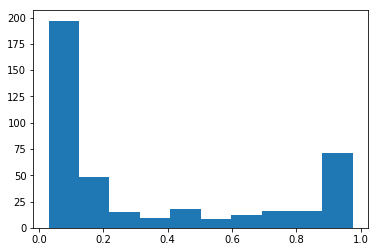

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(Y)
None

In [31]:
from snorkel import viewer
idx = np.argsort(Y)[::-1]
idx = idx[:100]
viewer.SentenceNgramViewer(
    candidates=[X[i] for i in idx], 
    session=session,
    gold=[X[i] for i in idx if Yg[i] == 1]
)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[19, 20], [42], [95]], [[71, 72], [93], [1, 68]], [[29], [50, 67], [15, 16, 17, 18,…